In [1]:
import pandas as pd
import numpy as np
import os
import enum
import time
import matplotlib.pyplot as plt
import utils
import json
import seaborn as sns
import ignite

from tqdm.auto import tqdm, trange

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchio as tio
import monai

import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.metrics import precision_recall_curve

from datetime import datetime

# from google.colab import drive

torch.manual_seed(7)
torch.set_grad_enabled(False)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [272]:
dfs = {}

for algorithm in ["logreg", "svm", "knn", "mlp", "gauss"]:
    dfs[algorithm] = utils.printTableUniMulti(
        f"../study/stats/results-{algorithm}-loo-filter-Uni-Multi.json",
        score="acc",
        skip_uni=["fechner_corr", "gini_index", "information_gain", "pearson_corr", "su_measure"],
        skip_multi=["CMIM", "IWFS", "JMI", "MIM"],
        add_uni={
            "Mannwhiten": f"../study/stats/results-{algorithm}-loo-filter-Man-Multi.json",
            "Mannwhiten+Kruscal": f"../study/stats/results-{algorithm}-loo-filter-ManKru-Multi.json"
        }
    )
    print()

                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.7143	0.6429	0.7662	0.8117	0.6429	0.7857	
        kendall_corr	0.7403	0.5000	0.7143	0.5000	0.6429	0.5000	
     reliefF_measure	0.5000	0.7662	0.5000	0.6429	0.5000	0.5000	
       spearman_corr	0.5000	0.5000	0.6688	0.5714	0.5000	0.5714	
          Mannwhiten	0.8117	0.7403	0.6429	0.7143	0.8117	0.6429	
  Mannwhiten+Kruscal	0.6429	0.7403	0.6429	0.7403	0.7403	0.7662	
                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.5000	0.5714	0.5000	0.5714	0.5000	0.5000	
        kendall_corr	0.5000	0.5000	0.5000	0.5000	0.5000	0.5000	
     reliefF_measure	0.5000	0.5000	0.5000	0.5714	0.5000	0.5000	
       spearman_corr	0.5000	0.5000	0.5000	0.5000	0.5000	0.5000	
          Mannwhiten	0.5000	0.5000	0.5000	0.5000	0.5000	0.5000	
  Mannwhiten+Kruscal	0.5000	0.5000	0.5000	0.5000	0.5000	0.5000	
                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.8117	0.5000	0.5974	0.8636	0.6429	0.7143	


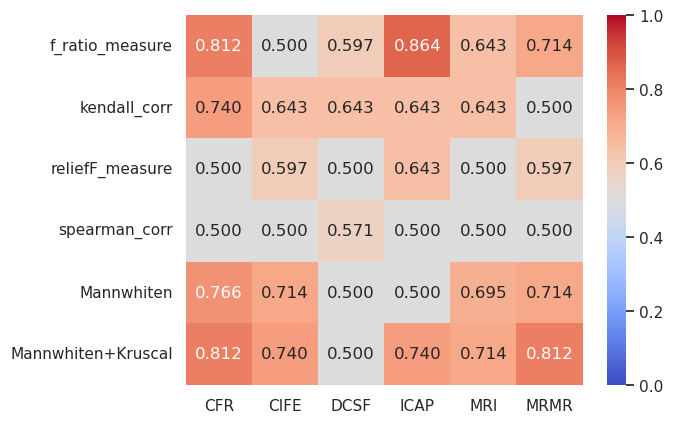

In [273]:
fig = sns.heatmap(dfs["knn"], annot=True, fmt=".3f", vmin=0, vmax=1, cmap="coolwarm")
# plt.title("Logistic Regression AUC-ROC score")
# plt.savefig("../imgs/prediction_scores/auc-logreg-uni+multi.png",dpi=300, bbox_inches="tight")

In [44]:
dfs = {}

for algorithm in ["logreg", "knn", "mlp", "gauss"]:
    dfs[algorithm] = utils.printTableUniMulti(
        f"../study/stats/results-{algorithm}-loo-filter-Uni-Multi-sfs.json",
        score="log",
        #skip_uni=["fechner_corr", "gini_index", "information_gain", "pearson_corr", "su_measure"],
        #skip_multi=["CMIM", "IWFS", "JMI", "MIM"],
        add_uni={
            "Mannwhiten": f"../study/stats/results-{algorithm}-loo-filter-Man-Multi-sfs.json",
            "Mannwhiten+Kruscal": f"../study/stats/results-{algorithm}-loo-filter-ManKru-Multi-sfs.json"
        }
    )
    print()

                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	1.3757	1.2722	1.0212	2.0620	1.6266	2.3985	
        kendall_corr	7.4243	7.4243	7.4243	7.4243	7.4243	7.4243	
     reliefF_measure	2.9103	1.3921	3.1298	0.9658	2.9460	1.0166	
       spearman_corr	0.9152	6.0126	1.4839	5.8752	5.9927	4.8411	
          Mannwhiten	2.3516	0.8310	1.5500	0.6323	0.4220	1.4535	
  Mannwhiten+Kruscal	2.1520	4.1250	0.4705	4.7247	2.5669	0.5003	
                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	6.5013	6.4534	4.2199	6.3088	2.5161	6.1998	
        kendall_corr	16.0194	16.0194	16.0194	16.0194	16.0194	16.0194	
     reliefF_measure	8.5648	6.4759	16.3434	10.4132	6.4374	10.1887	
       spearman_corr	12.2042	14.2095	6.3444	12.0981	16.0964	18.0218	
          Mannwhiten	12.4381	14.2931	14.1325	14.1870	8.3628	8.0867	
  Mannwhiten+Kruscal	20.1943	12.2391	8.1478	12.2005	20.2488	10.1887	
                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	2.3415	2.3402	0.9506

<Axes: >

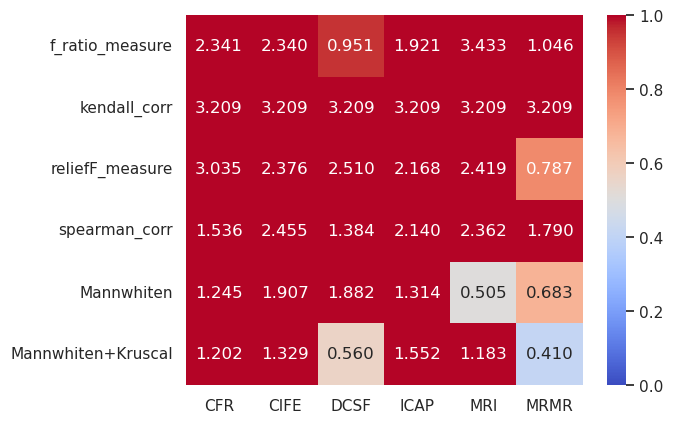

In [281]:
sns.heatmap(dfs["logreg"], annot=True, fmt=".3f", vmin=0, vmax=1, cmap="coolwarm")
# plt.title("Gaussian Naive Bayes AUC-ROC score + SFS(1, 15)")
# plt.savefig("../imgs/prediction_scores/auc-gauss-uni+multi+sfs.png",dpi=300, bbox_inches="tight")

In [2]:
df = utils.getReducedDS()
X, y, y3 = utils.splitFeatureLabels(df)

## Logistic Regression

In [147]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.pipeline import Pipeline
from ITMO_FS.filters import multivariate
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import make_scorer

cv_log = cross_validate(
    Pipeline([
        ("selection", Pipeline([
            ("outlier", utils.MADOutlierRemotion(3)),
            ("scaler", RobustScaler().set_output(transform="pandas")),
            ("t-test", utils.MannwhitenFilter(0.05)),
            ("ANOVA", utils.KruskalFilter(y3, 0.05)),
            ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
            ("multivariate", multivariate.MultivariateFilter("DCSF", 20)),
            ("sfs", SFS(
                LogisticRegression(random_state=7, class_weight="balanced"),
                k_features=(1,15),
                floating=True,
                scoring="roc_auc",
                cv=3,
            ))
        ])),
        ("clf", LogisticRegressionCV(
            random_state=7,
            class_weight="balanced",
            scoring="neg_log_loss",
            cv=3,
            n_jobs=1
        ))
    ]),
    X, y,
    scoring=make_scorer(utils.retScores, needs_proba=True),
    cv=LeaveOneOut(),
    n_jobs=-1,
    verbose=2,
    error_score="raise",
    return_estimator=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time= 3.7min
[CV] END .................................................... total time= 3.8min
[CV] END .................................................... total time= 3.8min
[CV] END .................................................... total time= 3.9min
[CV] END .................................................... total time= 3.9min
[CV] END .................................................... total time= 3.9min
[CV] END .................................................... total time= 4.2min
[CV] END .................................................... total time= 4.3min
[CV] END .................................................... total time= 3.4min
[CV] END .................................................... total time= 3.3min
[CV] END .................................................... total time= 3.1min
[CV] END .................................................... total time= 3.5min
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  7.5min remaining:  2.9min


[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 3.3min
[CV] END .................................................... total time= 1.5min
[CV] END .................................................... total time= 1.6min


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  8.9min finished


In [157]:
for estimator in cv_log["estimator"]:
    print(estimator["selection"]["sfs"].k_feature_names_)

('Right-Hippocampus_RD_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized',)
('Left-Accumbens-area_AD_lbp-3D-k_glcm_ClusterProminence', 'Right-Thalamus_wfvf_wavelet-HLL_glszm_SizeZoneNonUniformityNormalized')
('Right-Hippocampus_RD_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized',)
('Right-Hippocampus_RD_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized',)
('Right-Hippocampus_RD_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized',)
('Left-Accumbens-area_AD_lbp-3D-k_glcm_ClusterProminence', 'Right-Thalamus_wfvf_wavelet-HLL_glszm_SizeZoneNonUniformityNormalized')
('Right-Hippocampus_RD_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized',)
('Left-Accumbens-area_AD_lbp-3D-k_firstorder_Entropy', 'Right-Thalamus_wfvf_wavelet-HLL_glszm_SizeZoneNonUniformityNormalized')
('Right-Hippocampus_RD_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized',)
('Left-Accumbens-area_AD_lbp-3D-k_firstorder_Entropy', 'Right-Thalamus_wfvf_wavelet-HLL_glszm_SizeZoneNonUniformityNormalized')
('Right-Hippocampus_RD_w

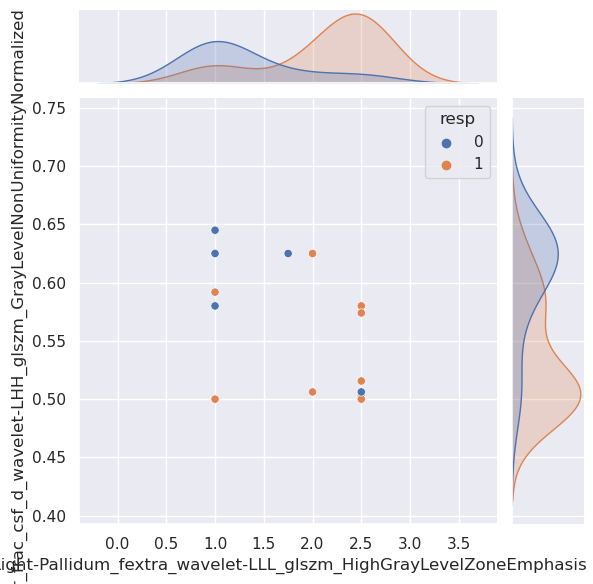

In [174]:
sns.jointplot(data=X, x='Right-Pallidum_fextra_wavelet-LLL_glszm_HighGrayLevelZoneEmphasis', y='lh.or_frac_csf_d_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized', hue=y, palette="deep")

AUC:		Test: 0.909
f1:		Test: 0.957
Accuracy:	Test: 0.857
Accuracy not adjusted: 0.929 0.944
Brier:		Test: 0.109
LogLoss:	Test 0.470


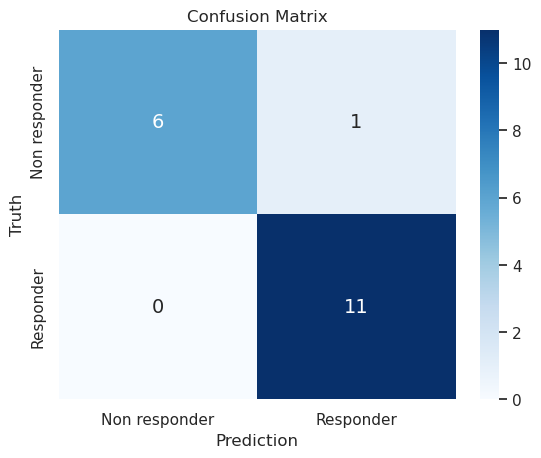

In [159]:
scores = utils.printScores(y, cv_log["test_score"], confusion=True)

In [8]:
def printScoresPredicions(scores, y, y3):
    return pd.concat([pd.Series(scores["prob_decision"], index=y.index),pd.Series(scores["prob_decision"]>=scores["threshold"], index=y.index), y, y3], axis=1)

In [160]:
printScoresPredicions(scores, y, y3)

,0,1,resp,respPart
ID,,,,
VNSLC_01,0.840411,True,1,2
VNSLC_02,1.000000,True,1,2
VNSLC_03,0.662642,True,1,2
VNSLC_04,0.840411,True,1,2
VNSLC_06,0.277690,False,0,0
VNSLC_07,0.603145,True,1,2
VNSLC_09,0.840411,True,1,2
VNSLC_10,1.000000,True,1,1
VNSLC_11,0.446106,True,1,2


## Gaussian 1

In [175]:
from sklearn.naive_bayes import GaussianNB

cv_gauss1 = cross_validate(
    Pipeline([
        ("selection", Pipeline([
            ("outlier", utils.MADOutlierRemotion(3)),
            ("scaler", RobustScaler().set_output(transform="pandas")),
            ("t-test", utils.MannwhitenFilter(0.05)),
            ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
            ("multivariate", multivariate.MultivariateFilter("MRI", 20)),
            ("sfs", SFS(
                GaussianNB(),
                k_features=(1,15),
                floating=True,
                scoring="roc_auc",
                cv=3,
            ))
        ])),
        ("clf", GaussianNB())
    ]),
    X, y,
    scoring=make_scorer(utils.retScores, needs_proba=True),
    cv=LeaveOneOut(),
    n_jobs=-1,
    verbose=2,
    error_score="raise",
    return_estimator=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time= 4.9min
[CV] END .................................................... total time= 5.2min
[CV] END .................................................... total time= 5.3min
[CV] END .................................................... total time= 5.3min
[CV] END .................................................... total time= 5.6min
[CV] END .................................................... total time= 5.7min
[CV] END .................................................... total time= 5.7min
[CV] END .................................................... total time= 6.0min
[CV] END .................................................... total time= 5.1min
[CV] END .................................................... total time= 4.7min
[CV] END .................................................... total time= 4.3min
[CV] END .................................................... total time= 4.8min
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed: 10.7min remaining:  4.1min


[CV] END .................................................... total time= 5.4min
[CV] END .................................................... total time= 5.1min
[CV] END .................................................... total time= 4.7min
[CV] END .................................................... total time= 1.9min
[CV] END .................................................... total time= 2.4min


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 12.5min finished


In [177]:
for estimator in cv_gauss["estimator"]:
    print(estimator["selection"]["sfs"].k_feature_names_)

('Left-Pallidum_frac_csf_d_wavelet-LLL_glszm_ZoneVariance', 'Right-Caudate_RD_wavelet-HHL_glszm_GrayLevelVariance')
('rh.ilf_fvf_tot_lbp-3D-m1_firstorder_Median', 'lh.cbv_frac_csf_d_wavelet-HLH_glszm_SizeZoneNonUniformity')
('rh.ar_wAD_wavelet-LHH_glszm_SizeZoneNonUniformity', 'lh.ar_wAD_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized')
('Right-Thalamus_wFA_wavelet-LLH_glszm_GrayLevelNonUniformityNormalized', 'Left-Caudate_fextra_lbp-3D-m1_firstorder_Median')
('lh.ar_wMD_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized', 'lh.or_frac_csf_d_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized')
('Left-Accumbens-area_AD_lbp-3D-k_glcm_ClusterProminence', 'Left-Caudate_frac_csf_mf_lbp-3D-k_glszm_SizeZoneNonUniformityNormalized')
('lh.ar_frac_csf_d_wavelet-LLH_glszm_GrayLevelNonUniformityNormalized', 'lh.cbd_wMD_lbp-3D-m1_firstorder_Median')
('lh.cbv_fiso_wavelet-HHH_glszm_GrayLevelNonUniformity', 'rh.atr_frac_csf_mf_wavelet-HLL_glszm_LowGrayLevelZoneEmphasis')
('Left-Caudate_fiso_lbp-3D-

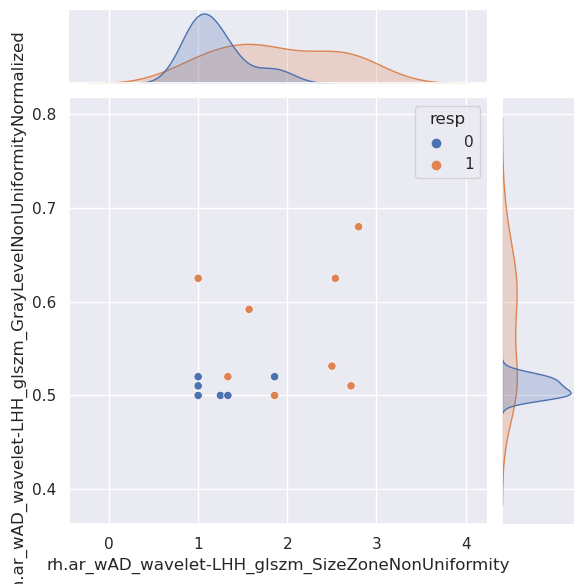

In [180]:
sns.jointplot(data=X, x='rh.ar_wAD_wavelet-LHH_glszm_SizeZoneNonUniformity', y='lh.ar_wAD_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized', hue=y, palette="deep")

AUC:		Test: 0.961
f1:		Test: 0.917
Accuracy:	Test: 0.714
Accuracy not adjusted: 0.857 0.889
Brier:		Test: 0.112
LogLoss:	Test 0.342


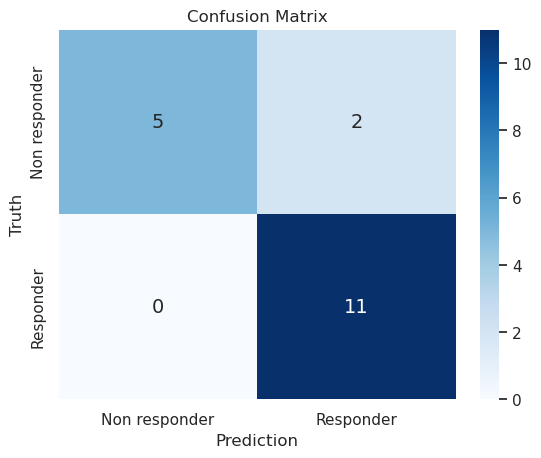

In [176]:
scores = utils.printScores(y, cv_gauss["test_score"], confusion=True)

In [91]:
printScoresPredicions(scores, y, y3)

,0,1,resp,respPart
ID,,,,
VNSLC_01,1.000000,True,1,2
VNSLC_02,0.080473,True,1,2
VNSLC_03,0.999864,True,1,2
VNSLC_04,1.000000,True,1,2
VNSLC_06,0.023621,False,0,0
VNSLC_07,0.487914,True,1,2
VNSLC_09,0.762465,True,1,2
VNSLC_10,0.999669,True,1,1
VNSLC_11,0.991134,True,1,2


## Gaussian 2

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.pipeline import Pipeline
from ITMO_FS.filters import multivariate
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import make_scorer

cv_gauss2 = cross_validate(
    Pipeline([
        ("selection", Pipeline([
            ("outlier", utils.MADOutlierRemotion(3)),
            ("scaler", RobustScaler().set_output(transform="pandas")),
            ("t-test", utils.MannwhitenFilter(0.05)),
            ("ANOVA", utils.KruskalFilter(y3, 0.05)),
            ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
            ("multivariate", multivariate.MultivariateFilter("DCSF", 20)),
            ("sfs", SFS(
                GaussianNB(),
                k_features=(1,15),
                floating=True,
                scoring="roc_auc",
                cv=3,
            ))
        ])),
        ("clf", GaussianNB())
    ]),
    X, y,
    scoring=make_scorer(utils.retScores, needs_proba=True),
    cv=LeaveOneOut(),
    n_jobs=-1,
    verbose=2,
    error_score="raise",
    return_estimator=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time= 3.2min
[CV] END .................................................... total time= 3.5min
[CV] END .................................................... total time= 3.4min
[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 3.7min
[CV] END .................................................... total time= 3.9min
[CV] END .................................................... total time= 3.4min
[CV] END .................................................... total time= 3.3min
[CV] END .................................................... total time= 3.3min
[CV] END .................................................... total time= 3.4min
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  7.2min remaining:  2.8min


[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 3.4min
[CV] END .................................................... total time= 1.6min
[CV] END .................................................... total time= 1.6min


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  8.7min finished


AUC:		Test: 0.857
f1:		Test: 0.957
Accuracy:	Test: 0.857
Accuracy not adjusted: 0.929 0.944
Brier:		Test: 0.082
LogLoss:	Test 1.589


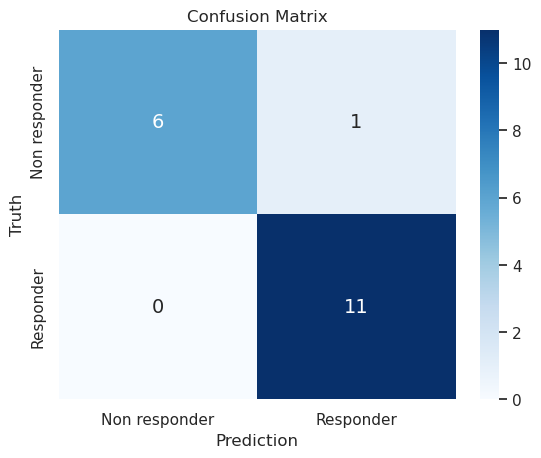

In [22]:
scores = utils.printScores(y, cv_gauss2["test_score"], confusion=True)

In [9]:
printScoresPredicions(scores, y, y3)

,0,1,resp,respPart
ID,,,,
VNSLC_01,0.994070,True,1,2
VNSLC_02,0.999621,True,1,2
VNSLC_03,0.986850,True,1,2
VNSLC_04,0.994070,True,1,2
VNSLC_06,0.092562,False,0,0
VNSLC_07,0.794415,True,1,2
VNSLC_09,0.994070,True,1,2
VNSLC_10,0.999558,True,1,1
VNSLC_11,0.409380,True,1,2


## Gaussian ensemble

In [49]:
from sklearn.ensemble import VotingClassifier
from sklearn import set_config
set_config(transform_output="pandas")

model1 = Pipeline([
    ("selection", Pipeline([
        ("outlier", utils.MADOutlierRemotion(3)),
        ("scaler", RobustScaler()),
        ("t-test", utils.MannwhitenFilter(0.05)),
        ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
        ("multivariate", multivariate.MultivariateFilter("MRI", 20)),
        ("sfs", SFS(
            GaussianNB(),
            k_features=(1,15),
            floating=True,
            scoring="roc_auc",
            cv=3,
        ))
    ])),
    ("clf", GaussianNB())
])

model2 = Pipeline([
    ("selection", Pipeline([
        ("outlier", utils.MADOutlierRemotion(3)),
        ("scaler", RobustScaler()),
        ("t-test", utils.MannwhitenFilter(0.05)),
        ("ANOVA", utils.KruskalFilter(y3, 0.05)),
        ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
        ("multivariate", multivariate.MultivariateFilter("DCSF", 20)),
        ("sfs", SFS(
            GaussianNB(),
            k_features=(1,15),
            floating=True,
            scoring="roc_auc",
            cv=3,
        ))
    ])),
    ("clf", GaussianNB())
])

model3 = Pipeline([
    ("selection", Pipeline([
        ("outlier", utils.MADOutlierRemotion(3)),
        ("scaler", RobustScaler().set_output(transform="pandas")),
        ("t-test", utils.MannwhitenFilter(0.05)),
        ("ANOVA", utils.KruskalFilter(y3, 0.05)),
        ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
        ("multivariate", multivariate.MultivariateFilter("DCSF", 20)),
        ("sfs", SFS(
            LogisticRegression(random_state=7, class_weight="balanced"),
            k_features=(1,15),
            floating=True,
            scoring="roc_auc",
            cv=3,
        ))
    ])),
    ("clf", LogisticRegressionCV(
        random_state=7,
        class_weight="balanced",
        scoring="neg_log_loss",
        cv=3,
        n_jobs=1
    ))
])

# Try adding the calibration
ensemble_model = VotingClassifier(
    estimators= [
        ("gauss1", model1),
        ("gauss2", model3),
    ],
    voting="soft"
)

cv_gauss_ensemble = cross_validate(
    ensemble_model,
    X, y,
    scoring=make_scorer(utils.retScores, needs_proba=True),
    cv=LeaveOneOut(),
    n_jobs=-1,
    verbose=2,
    error_score="raise",
    return_estimator=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time= 8.5min
[CV] END .................................................... total time= 8.9min
[CV] END .................................................... total time= 9.1min
[CV] END .................................................... total time= 9.5min
[CV] END .................................................... total time= 9.5min
[CV] END .................................................... total time= 9.8min
[CV] END .................................................... total time=10.2min
[CV] END .................................................... total time=10.4min
[CV] END .................................................... total time= 9.5min
[CV] END .................................................... total time= 9.0min
[CV] END .................................................... total time= 8.8min
[CV] END .................................................... total time= 8.5min
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed: 19.0min remaining:  7.3min


[CV] END .................................................... total time= 8.8min
[CV] END .................................................... total time= 9.6min
[CV] END .................................................... total time= 9.9min
[CV] END .................................................... total time= 4.0min
[CV] END .................................................... total time= 4.5min


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 22.9min finished


AUC:		Test: 0.987
f1:		Test: 0.957
Accuracy:	Test: 0.857
Accuracy not adjusted: 0.929 0.944
Brier:		Test: 0.075
LogLoss:	Test 0.262


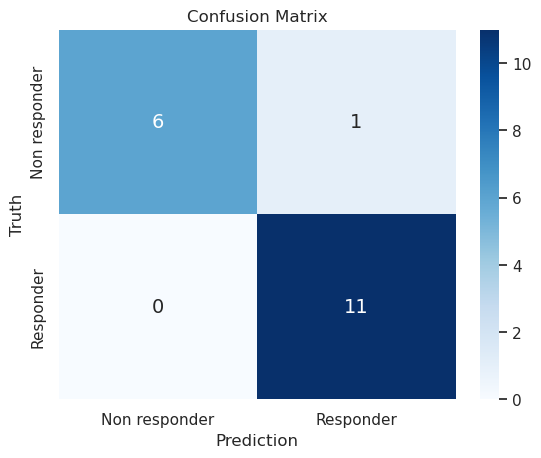

In [54]:
scores = utils.printScores(y, cv_gauss_ensemble["test_score"], confusion=True)

In [55]:
scores["threshold"]

0.41057536438748893

In [56]:
printScoresPredicions(scores, y, y3)

,0,1,resp,respPart
ID,,,,
VNSLC_01,0.920205,True,1,2
VNSLC_02,0.540237,True,1,2
VNSLC_03,0.831253,True,1,2
VNSLC_04,0.920205,True,1,2
VNSLC_06,0.150656,False,0,0
VNSLC_07,0.545529,True,1,2
VNSLC_09,0.801438,True,1,2
VNSLC_10,0.999835,True,1,1
VNSLC_11,0.718620,True,1,2


## MLP

In [181]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy import stats

cv_best_mlp = cross_validate(
    Pipeline([
        ("selection", Pipeline([
            ("outlier", utils.MADOutlierRemotion(3)),
            ("scaler", RobustScaler().set_output(transform="pandas")),
            ("t-test", utils.MannwhitenFilter(0.05)),
            ("ANOVA", utils.KruskalFilter(y3, 0.05)),
            ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
            ("multivariate", multivariate.MultivariateFilter("MRMR", 20)),
            ("sfs", SFS(
                MLPClassifier(random_state=7, learning_rate="adaptive", max_iter=1000),
                k_features=(1,15),
                floating=True,
                scoring="roc_auc",
                cv=3,
            ))
        ])),
        ("clf", RandomizedSearchCV(
            MLPClassifier(random_state=7, learning_rate="adaptive", max_iter=1000),
            param_distributions={
                "alpha": stats.loguniform(1e-3, 1e1),
                "hidden_layer_sizes": [(100,), (50,), (20,)]
            },
            scoring="neg_log_loss", cv=3, n_jobs=1, random_state=7
        ))
    ]),
    X, y,
    scoring=make_scorer(utils.retScores, needs_proba=True),
    cv=LeaveOneOut(),
    n_jobs=-1,
    verbose=2,
    error_score="raise",
    return_estimator=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximu

[CV] END .................................................... total time= 5.7min


/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .................................................... total time= 5.7min


/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .................................................... total time= 6.0min
[CV] END .................................................... total time= 6.1min
[CV] END .................................................... total time= 6.1min
[CV] END .................................................... total time= 6.2min
[CV] END .................................................... total time= 6.1min
[CV] END .................................................... total time= 6.2min


/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

[CV] END .................................................... total time= 5.9min


/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .................................................... total time= 5.5min


/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .................................................... total time= 5.7min


/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

[CV] END .................................................... total time= 6.1min
[CV] END .................................................... total time= 5.9min


[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed: 12.1min remaining:  4.6min


[CV] END .................................................... total time= 6.0min
[CV] END .................................................... total time= 5.9min
[CV] END .................................................... total time= 6.1min


/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

[CV] END .................................................... total time= 2.9min
[CV] END .................................................... total time= 2.9min


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 14.7min finished


In [182]:
for estimator in cv_gauss["estimator"]:
    print(estimator["selection"]["sfs"].k_feature_names_)

('Left-Pallidum_frac_csf_d_wavelet-LLL_glszm_ZoneVariance', 'Right-Caudate_RD_wavelet-HHL_glszm_GrayLevelVariance')
('rh.ilf_fvf_tot_lbp-3D-m1_firstorder_Median', 'lh.cbv_frac_csf_d_wavelet-HLH_glszm_SizeZoneNonUniformity')
('rh.ar_wAD_wavelet-LHH_glszm_SizeZoneNonUniformity', 'lh.ar_wAD_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized')
('Right-Thalamus_wFA_wavelet-LLH_glszm_GrayLevelNonUniformityNormalized', 'Left-Caudate_fextra_lbp-3D-m1_firstorder_Median')
('lh.ar_wMD_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized', 'lh.or_frac_csf_d_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized')
('Left-Accumbens-area_AD_lbp-3D-k_glcm_ClusterProminence', 'Left-Caudate_frac_csf_mf_lbp-3D-k_glszm_SizeZoneNonUniformityNormalized')
('lh.ar_frac_csf_d_wavelet-LLH_glszm_GrayLevelNonUniformityNormalized', 'lh.cbd_wMD_lbp-3D-m1_firstorder_Median')
('lh.cbv_fiso_wavelet-HHH_glszm_GrayLevelNonUniformity', 'rh.atr_frac_csf_mf_wavelet-HLL_glszm_LowGrayLevelZoneEmphasis')
('Left-Caudate_fiso_lbp-3D-

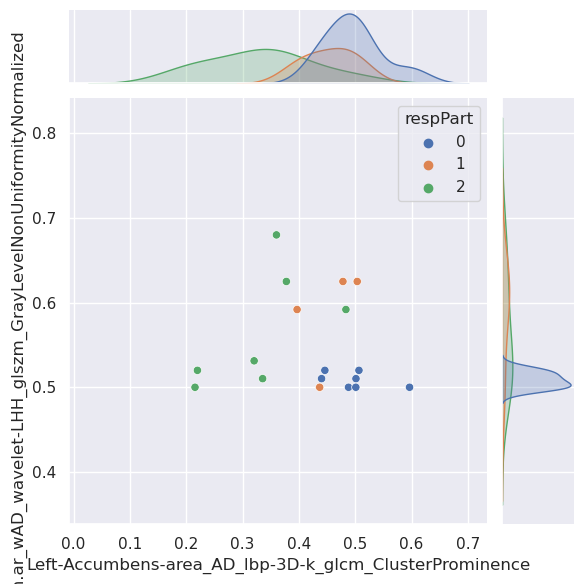

In [189]:
sns.jointplot(data=X, x='Left-Accumbens-area_AD_lbp-3D-k_glcm_ClusterProminence', y='lh.ar_wAD_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized', hue=y3, palette="deep")

AUC:		Test: 0.909
f1:		Test: 0.909
Accuracy:	Test: 0.766
Accuracy not adjusted: 0.883 0.889
Brier:		Test: 0.130
LogLoss:	Test 0.410


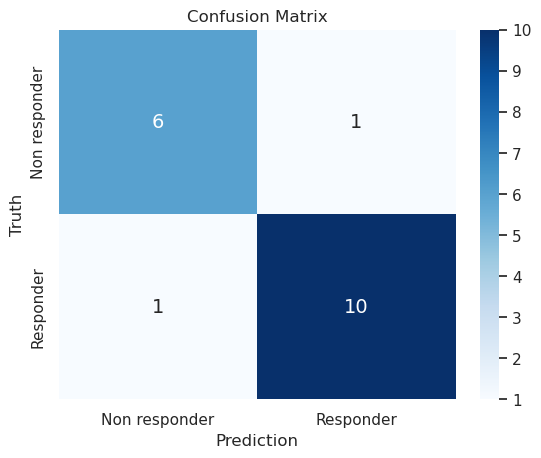

In [190]:
scores = utils.printScores(y, cv_best_mlp["test_score"], confusion=True)

In [124]:
scores["threshold"]

0.5028289716351725

In [122]:
printScoresPredicions(scores)

,0,1,resp,respPart
ID,,,,
VNSLC_01,0.902078,True,1,2
VNSLC_02,0.902078,True,1,2
VNSLC_03,0.751549,True,1,2
VNSLC_04,0.902078,True,1,2
VNSLC_06,0.351906,False,0,0
VNSLC_07,0.902078,True,1,2
VNSLC_09,0.902078,True,1,2
VNSLC_10,0.191709,False,1,1
VNSLC_11,0.502829,True,1,2


## Calibration

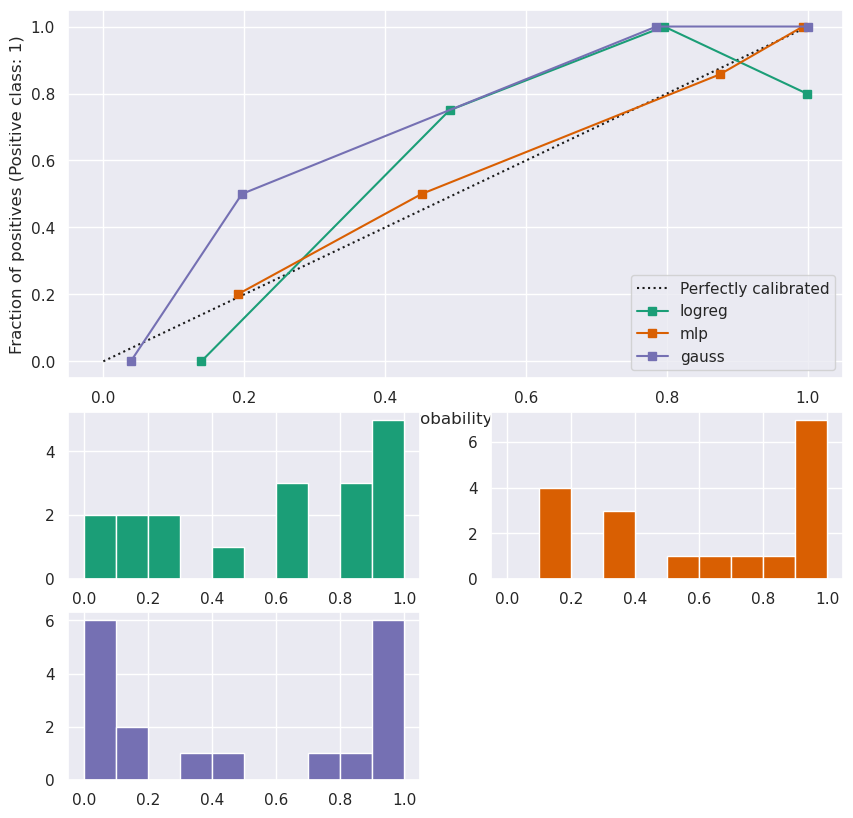

In [332]:
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
bins = 4

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])

cal = []
cal.append(CalibrationDisplay.from_predictions(y, cv_log["test_score"],n_bins=bins,strategy="quantile", name="logreg", ax=ax_calibration_curve, color=colors(0)))
cal.append(CalibrationDisplay.from_predictions(y, cv_best_mlp["test_score"],n_bins=bins, strategy="quantile", name="mlp", ax=ax_calibration_curve, color=colors(1)))
cal.append(CalibrationDisplay.from_predictions(y, cv_gauss["test_score"],n_bins=bins, strategy="quantile", name="gauss", ax=ax_calibration_curve, color=colors(2)))

grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, name in enumerate(["logreg", "mlp", "gauss"]):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        cal[i].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )

# pytorch

In [2]:
study_path = "../study"

info_df = pd.read_csv(f"{study_path}/stats/info.csv").dropna()

subjects_list = []

for idx, row in info_df.iterrows():
    if "VNSLC" not in row.ID:
        continue
    
    subj_dict = {
        "id": row.ID,
        "resp": row.resp, # Prova cambiando in 0, 0.75, 1
        "age": row.age,
        "sex": row.sex,
        "epilepsy_type": row.epilepsy_type,
        "epilepsy_onset_age": row.epilepsy_onset_age,
        "therapy_duration": row.therapy_duration,
        "AEDs": row.AEDs,
        "FA": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_FA.nii.gz"),
        "MD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_MD.nii.gz"),
        "AD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_AD.nii.gz"),
        "RD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_RD.nii.gz"),
        "wFA": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wFA.nii.gz"),
        "wMD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wMD.nii.gz"),
        "wAD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wAD.nii.gz"),
        "wRD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wRD.nii.gz"),
        "diamond_frac_csf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_frac_csf.nii.gz"),
        "icvf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_icvf.nii.gz"),
        "odi": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_odi.nii.gz"),
        "fextra": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_fextra.nii.gz"),
        "fiso": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_fiso.nii.gz"),
        "wfvf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_wfvf.nii.gz"),
        "fvf_tot": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_fvf_tot.nii.gz"),
        "mf_frac_csf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_frac_csf.nii.gz"),
        "WM_mask": tio.LabelMap(f"{study_path}/freesurfer/{row.ID}/dlabel/diff/White-Matter++.bbr.nii.gz"),
        "aparc_aseg": tio.LabelMap(f"{study_path}/freesurfer/{row.ID}/dlabel/diff/aparc+aseg+thalnuc.bbr.nii.gz"),
        # "tract_prob": tio.ScalarImage(f"{study_path}/freesurfer/{row.ID}/dpath/mergedX2_3D_avg16_syn_bbr.nii.gz"),
        "t1": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/registration/{row.ID}_T1_brain_reg.nii.gz"),
    }

    subjects_list.append(tio.Subject(subj_dict))

## Batch

Rimuovo i voxel vuoti per risparmiare spazio, lo faccio croppando tutte le immagini e mantenendo solo il brain. Dopodichè non essendo tutti i subjects registrati, non sono tutti nella stessa direzione e quindi il crop a generato volumi con shape diversi, mi trovo le dimensioni massime e adatto tutti i volumi a quella.

Questo processo è utile solo se si vuole fare un analisy by batch. Mentre quella by path non richiede tutti i volumi della stessa dimenzione in quanto estrae delle slides

In [11]:
transformation = tio.Compose([
    tio.transforms.ToCanonical(),
    tio.transforms.Resample("FA"),
    tio.transforms.CropOrPad(mask_name="aparc_aseg"),
    tio.transforms.CopyAffine("FA"),
])
max = [0, 0, 0]
for subj in subjects_list:
    subj_transformed = transformation(subj)
    for i in range(3):
        if subj_transformed.shape[i+1] > max[i]:
            max[i] = subj_transformed.shape[i+1]

In [80]:
preprocessing_transform = tio.Compose([
    ## Preprocessing ##
    # Spatial
    tio.transforms.ToCanonical(),
    tio.transforms.Resample("FA"),
    tio.transforms.CropOrPad((max[0], max[1], max[2])),
    tio.transforms.CopyAffine("FA"),
    tio.transforms.EnsureShapeMultiple(8, method="crop"),
    # Voxel Intensity
    tio.transforms.Mask(masking_method="aparc_aseg"),
    # tio.transforms.RescaleIntensity(percentiles=(0.5, 99.5), masking_method="aparc_aseg"),
    tio.ZNormalization(masking_method="aparc_aseg"),
])

In [3]:
training_transform = tio.Compose([
    tio.OneOf({
        tio.RandomAffine(scales=0.25, degrees=20, translation=5, check_shape=True): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
    tio.RandomAnisotropy(downsampling=(1.5, 6), p=0.2),
    tio.RandomBiasField(p=0.2),
    tio.RandomBlur(std=(0, 4), p=0.2),
    tio.RandomGamma(p=0.2),
    tio.RandomNoise(p=0.2),
    tio.OneOf((
        tio.RandomMotion(),
        tio.RandomGhosting(),
        tio.RandomSpike(),
    ), p=0.2),
    tio.RandomSwap(patch_size=5, p=0.2),
])

validation_transform = tio.Compose([
    tio.OneOf({
        tio.RandomAffine(scales=0.25, degrees=20, translation=5, check_shape=True): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
    tio.RandomAnisotropy(downsampling=(1.5, 6), p=0.2),
    tio.RandomBiasField(p=0.2),
    tio.RandomBlur(std=(0, 4), p=0.2),
    tio.RandomGamma(p=0.2),
    tio.RandomNoise(p=0.2),
    tio.OneOf((
        tio.RandomMotion(),
        tio.RandomGhosting(),
        tio.RandomSpike(),
    ), p=0.2),
])

testing_transform = tio.Compose([
    tio.RandomAffine(scales=0.05, degrees=5, check_shape=True),
    tio.RandomAnisotropy(downsampling=(1, 2), p=0.2),
    tio.RandomBiasField(coefficients=0.25, p=0.2),
    tio.RandomBlur(std=(0, 2), p=0.2),
    tio.RandomGamma(log_gamma=(-1.5, 1.5), p=0.2),
    tio.RandomNoise(std=(0, 0.1), p=0.2),
])

In [ ]:
def looPytorch():
  avg_score = []

  for train_val_idx, test_idx in LeaveOneOut().split(info_df):
    train_val = info_df.iloc[train_val_idx, :]
    test = info_df.iloc[test_idx, :]
    for train_idx, val_idx in LeaveOneOut().split(train_val):
      train = train_val.iloc[train_idx, :]
      val = train_val.iloc[val_idx, :]

      print(train_idx)

      # evaluate the model, fo the hyperParameters selection

    # Select the best model and use it for the test
    # test the model, compute the score and add tot the list

  # mean of avg_score
  return np.mean(avg_score)


In [6]:
test = [2, 16, 13, 12]
val = [0, 7, 10, 14]
train = set(range(19))
for el_test in test+val:
    train.remove(el_test)
train = list(train)

training_subjects = []
validation_subjects = []
testing_subjects = []

for idx in train:
    training_subjects.append(subjects_list[idx])
for idx in val:
    validation_subjects.append(subjects_list[idx])
for idx in test:
    testing_subjects.append(subjects_list[idx])

k=100

training_set = tio.SubjectsDataset(
    training_subjects*k, transform=tio.Compose([preprocessing_transform, training_transform])
)
validation_set = tio.SubjectsDataset(
    validation_subjects*k, transform=tio.Compose([preprocessing_transform, validation_transform])
)
testing_set = tio.SubjectsDataset(
    testing_subjects*k, transform=tio.Compose([preprocessing_transform, testing_transform])
)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')
print('Test set:', len(testing_set), 'subjects')

Training set: 1100 subjects
Validation set: 400 subjects
Test set: 400 subjects


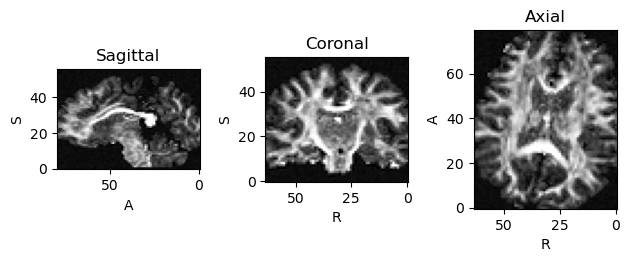

In [49]:
testing_set[2]["FA"].plot()

In [10]:
training_batch_size = 9
validation_batch_size = 9
testing_batch_size = 9

training_loader = DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
)

validation_loader = DataLoader(
    validation_set,
    batch_size=validation_batch_size,
)

testing_loader = DataLoader(
    testing_set,
    batch_size=testing_batch_size,
)

In [7]:
class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

class ModelTrainer():

    def __init__(self, training_loader, validation_loader, model, device, last_activation_function, loss_function, optimizer, metrics, model_file_out, writer):
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.model = model
        self.device = device
        self.last_activation_function = last_activation_function
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.metrics = metrics
        self.model_file_out = model_file_out
        self.epoch_number = 0
        self.writer = writer

    def __prepare_batch(self, batch):
        channels = []
        for image_type in ['FA', 'MD', 'AD', 'RD', 'wFA', 'wMD', 'wAD', 'wRD', 'diamond_frac_csf', 'icvf', 'odi', 'fextra', 'fiso', 'wfvf', 'fvf_tot', 'mf_frac_csf', 't1']:
            channels.append(batch[image_type][tio.DATA])
        inputs = torch.cat(channels, dim=1).to(self.device)
        targets = batch["resp"][np.newaxis].T.to(self.device).to(torch.float)
        return inputs, targets

    def __get_probabilities(self, logist):
        return self.last_activation_function(logist)

    def __get_losses(self, logists, targets):
        return self.loss_function(logists, targets)
    
    def __get_predictions(self, probs, targets):
        # probs_np = probs.detach().cpu().numpy()
        # precisions, recalls, thresholds = precision_recall_curve(targets.cpu().numpy(), probs_np)
        # best_f1_index = np.argmax([ utils.calc_f1(p_r) for p_r in zip(precisions, recalls)])
        # best_threshold = thresholds[best_f1_index]
        return torch.where(probs >= 0.5, 1, 0)

    def __runEpoch(self, action, loader):
        is_training = action == Action.TRAIN
        epoch_losses = []
        times = []
        self.model.train(is_training)
        for batch_idx, batch in enumerate(tqdm(loader)):
            inputs, targets = self.__prepare_batch(batch)
            self.optimizer.zero_grad(set_to_none=True)
            with torch.set_grad_enabled(is_training):
                logist = self.model(inputs)
                probabilities = self.__get_probabilities(logist)
                batch_losses = self.__get_losses(probabilities, targets)
                batch_loss = batch_losses.mean()
                if is_training:
                    batch_loss.backward()
                    self.optimizer.step()
                times.append(time.time())
                epoch_losses.append(batch_loss.item())
                predictions = self.__get_predictions(probabilities, targets)
                self.metrics.update("Accuracy", predictions, targets)
                self.metrics.update("f1", predictions, targets)
                self.metrics.update("AUC", probabilities, targets)
        epoch_losses = np.array(epoch_losses)
        self.metrics.compute(action)
        print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')

        return times, epoch_losses


    def train(self, epochs):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        train_losses = []
        val_losses = []

        self.metrics.reset()
        val_losses.append(self.__runEpoch(Action.VALIDATE, self.validation_loader))
        self.metrics.clear()

        self.writer.add_scalars('training_validation_loss', {"validation_loss": val_losses[-1][1].mean()}, self.epoch_number)
        
        for epoch in range(epochs):
            print("EPOCH {}".format(self.epoch_number + 1))
            self.metrics.reset()
            train_losses.append(self.__runEpoch(Action.TRAIN, self.training_loader))
            self.metrics.reset()
            val_losses.append(self.__runEpoch(Action.VALIDATE, self.validation_loader))
            print(self.metrics)

            self.writer.add_scalars(
                'loss',
                {
                    "training": train_losses[-1][1].mean(),
                    "validation" : val_losses[-1][1].mean(),
                },
                self.epoch_number+1
            )

            self.writer.add_scalars(
                "AUC",
                {
                    "training": self.metrics.df.loc[Action.TRAIN, "AUC"],
                    "validation": self.metrics.df.loc[Action.VALIDATE, "AUC"]
                },
                self.epoch_number+1
            )

            self.writer.add_scalars(
                "acc",
                {
                    "training": self.metrics.df.loc[Action.TRAIN, "Accuracy"],
                    "validation": self.metrics.df.loc[Action.VALIDATE, "Accuracy"]
                },
                self.epoch_number+1
            )

            self.writer.add_scalars(
                "f1",
                {
                    "training": self.metrics.df.loc[Action.TRAIN, "f1"],
                    "validation": self.metrics.df.loc[Action.VALIDATE, "f1"]
                },
                self.epoch_number+1
            )

            self.metrics.clear()

            torch.save(self.model.state_dict(), f'{self.model_file_out}_epoch_{self.epoch_number+1}.pth')
            self.epoch_number += 1
        self.metrics.clear()

        return np.array(train_losses), np.array(val_losses)
    

    def test(self, epochs):
        pass

class MetricsList():
    def __init__(self, **kwargs):
        self.metrics = kwargs.values()
        self.df = pd.DataFrame(columns=kwargs.keys())
    def update(self, metric_name, logist_pred, labels):
        if metric_name not in self.df.columns:
            raise Exception()
        metric_idx = np.where(self.df.columns == metric_name)[0][0]
        _ = [metric.update((logist_pred, labels)) for i, metric in enumerate(self.metrics) if i == metric_idx]
    def reset(self):
        _ = [metric.reset() for metric in self.metrics]
    def clear(self):
        self.df = self.df.iloc[0:0]  # Clear Dataframe
    def compute(self, mode):
        self.df.loc[mode] = [metric.compute() for metric in self.metrics]
    def __str__(self):
        return str(self.df)

In [12]:
from ignite.contrib.metrics import ROC_AUC
net = monai.networks.nets.ResNet(
    block="bottleneck",
    layers=[2, 2, 2, 2],
    block_inplanes=[64, 128, 256, 512],
    n_input_channels=17,
    num_classes=1,
).to(device)
optimizer = torch.optim.AdamW(net.parameters())
metrics = MetricsList(
    Accuracy=ignite.metrics.Accuracy(device=device),
    f1=ignite.metrics.Fbeta(beta=1, device=device),
    AUC=ROC_AUC(device=device)
)
writer = SummaryWriter('../study/models/run/test')

model_trainer = ModelTrainer(training_loader, validation_loader, net, device, torch.nn.Sigmoid(), torch.nn.BCELoss(reduction="none"), optimizer, metrics, "../study/models/whole_images", writer)

train_losses = None
val_losses = None

# Print on TensorBoard the model
# b = next(iter(training_loader))
# channels = []
# for image_type in ['FA', 'MD', 'AD', 'RD', 'wFA', 'wMD', 'wAD', 'wRD', 'diamond_frac_csf', 'icvf', 'odi', 'fextra', 'fiso', 'wfvf', 'fvf_tot', 'mf_frac_csf', 't1']:
#     channels.append(b[image_type][tio.DATA])
# inputs = torch.cat(channels, dim=1).to(device)
# writer.add_graph(model_trainer.model, inputs)

In [13]:
train_losses_cur, val_losses_cur = model_trainer.train(50)

if train_losses is None and val_losses is None:
    train_losses, val_losses = train_losses_cur, val_losses_cur
else:
    train_losses = np.concatenate([train_losses, train_losses_cur])
    val_losses = np.concatenate([val_losses, val_losses_cur])

checkpoint = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "weights": model_trainer.model.state_dict(),
}
torch.save(checkpoint, "../study/models/whole_images_state_dict.pth")

 22%|██▏       | 10/45 [07:08<24:59, 42.84s/it]


KeyboardInterrupt: 

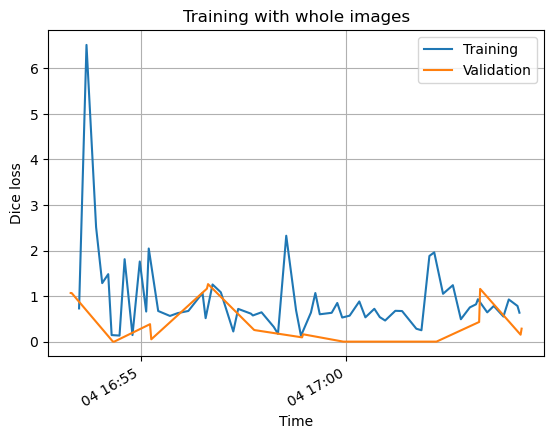

In [11]:
def plot_times(axis, losses, label):
    from datetime import datetime
    times, losses = losses.transpose(1, 0, 2)
    times = [datetime.fromtimestamp(x) for x in times.flatten()]
    axis.plot(times, losses.flatten(), label=label)

fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss')
ax.set_title('Training with whole images')
ax.legend()
fig.autofmt_xdate()

## Patch

In [4]:
preprocessing_transform = tio.Compose([
    ## Preprocessing ##
    # Spatial
    tio.transforms.ToCanonical(),
    tio.transforms.Resample("FA"),
    tio.transforms.CropOrPad(mask_name="aparc_aseg"),
    tio.transforms.CopyAffine("FA"),
    tio.transforms.EnsureShapeMultiple(8, method="crop"),
    # Voxel Intensity
    tio.transforms.Mask(masking_method="aparc_aseg"),
    # tio.transforms.RescaleIntensity(percentiles=(0.5, 99.5), masking_method="aparc_aseg"),
    tio.ZNormalization(masking_method="aparc_aseg"),
])

test = [2, 16, 13, 12]
val = [0, 7, 10, 14]
train = set(range(19))
for el_test in test+val:
    train.remove(el_test)
train = list(train)

training_subjects = []
validation_subjects = []
testing_subjects = []

for idx in train:
    training_subjects.append(subjects_list[idx])
for idx in val:
    validation_subjects.append(subjects_list[idx])
for idx in test:
    testing_subjects.append(subjects_list[idx])

k=100

training_set = tio.SubjectsDataset(
    training_subjects*k, transform=tio.Compose([preprocessing_transform, training_transform])
)
validation_set = tio.SubjectsDataset(
    validation_subjects*k, transform=tio.Compose([preprocessing_transform, validation_transform])
)
testing_set = tio.SubjectsDataset(
    testing_subjects*k, transform=tio.Compose([preprocessing_transform, testing_transform])
)

In [5]:
num_workers=8

training_batch_size = 64
validation_batch_size = 128
testing_batch_size = 128

patch_size = 10 # 3D batches of 2cmx2cmx2cm
samples_per_volume = 27 # in an hypotetic grid 3x3x3 a side will be of 6cm, wich is inside the brain
max_queue_lenght = 1024

sampler = tio.data.LabelSampler(
    patch_size=patch_size,
    label_name="WM_mask",
)

patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_lenght,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_lenght,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    shuffle_subjects=False,
    shuffle_patches=False,
    num_workers=num_workers
)

patches_test_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_lenght,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    shuffle_subjects=False,
    shuffle_patches=False,
    num_workers=num_workers
)

training_loader_patches = DataLoader(
    patches_training_set,
    batch_size=training_batch_size,
    shuffle=True,
)

validation_loader_patches = DataLoader(
    patches_validation_set,
    batch_size=validation_batch_size,
)

testing_loader_patches = DataLoader(
    patches_test_set,
    batch_size=testing_batch_size,
)

print('Training set:', len(patches_training_set), 'patch')
print('Validation set:', len(patches_validation_set), 'patch')
print('Test set:', len(patches_test_set), 'patch')

Training set: 29700 patch
Validation set: 10800 patch
Test set: 10800 patch


In [8]:
from ignite.contrib.metrics import ROC_AUC
net = monai.networks.nets.ResNet(
    block="bottleneck",
    layers=[2, 2, 2, 2],
    block_inplanes=[64, 128, 256, 512],
    n_input_channels=17,
    num_classes=1,
).to(device)
optimizer = torch.optim.AdamW(net.parameters())
metrics = MetricsList(
    Accuracy=ignite.metrics.Accuracy(device=device),
    f1=ignite.metrics.Fbeta(beta=1, device=device),
    AUC=ROC_AUC(device=device)
)
writer = SummaryWriter('../study/models/run/test_patch')

model_trainer = ModelTrainer(training_loader_patches, validation_loader_patches, net, device, torch.nn.Sigmoid(), torch.nn.BCELoss(reduction="none"), optimizer, metrics, "../study/models/whole_images", writer)

train_losses = None
val_losses = None

In [9]:
train_losses_cur, val_losses_cur = model_trainer.train(50)

if train_losses is None and val_losses is None:
    train_losses, val_losses = train_losses_cur, val_losses_cur
else:
    train_losses = np.concatenate([train_losses, train_losses_cur])
    val_losses = np.concatenate([val_losses, val_losses_cur])

checkpoint = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "weights": model_trainer.model.state_dict(),
}
torch.save(checkpoint, "../study/models/whole_images_state_dict.pth")

  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 85/85 [08:39<00:00,  6.11s/it] 


Validation mean loss: 0.693
EPOCH 1


 10%|█         | 48/465 [03:23<29:31,  4.25s/it]  


KeyboardInterrupt: 

# Download datsets

In [193]:
ixi_dataset = tio.datasets.ixi.IXI(
    "../study/ixi_root/",
    transform=preprocessing_transform,
    download=True,
    modalities=("DTI",)
)

# Dummy test

## Batch

In [68]:
b = next(iter(training_loader))

inputs = torch.cat([b["FA"][tio.DATA], b["fvf_tot"][tio.DATA]], dim=1).to(device)
labels = b["resp"][np.newaxis].T.to(device).to(torch.float)

In [69]:
net = monai.networks.nets.ResNet(
    block="bottleneck",
    layers=[2, 2, 2, 2],
    block_inplanes=[64, 128, 256, 512],
    n_input_channels=2,
    num_classes=1,
).to(device)

In [70]:
logit = net(inputs)
logit

tensor([[1.3968],
        [1.4738],
        [1.5581]], device='cuda:0')

In [71]:
labels

tensor([[1.],
        [0.],
        [1.]], device='cuda:0')

In [72]:
proba = torch.nn.Sigmoid()(logit)
proba

tensor([[0.8017],
        [0.8136],
        [0.8261]], device='cuda:0')

In [73]:
loss = torch.nn.BCELoss(reduction="none")(proba, labels)
loss.mean()

tensor(0.6974, device='cuda:0')

In [80]:
def get_predictions(probs, targets):
    probs_np = probs.cpu().numpy()
    precisions, recalls, thresholds = precision_recall_curve(targets.cpu().numpy(), probs_np)
    best_f1_index = np.argmax([ utils.calc_f1(p_r) for p_r in zip(precisions, recalls)])
    best_threshold = thresholds[best_f1_index]
    return torch.tensor(np.where(probs_np >= best_threshold, 1, 0), device=device, dtype=torch.float)

In [81]:
get_predictions(proba, labels)

tensor([[1],
        [1],
        [1]], device='cuda:0')

## Patch

In [59]:
b = next(iter(training_loader_patches))

In [60]:
k = int(patch_size // 4)
inputs = torch.cat([b["FA"][tio.DATA][..., k], b["fvf_tot"][tio.DATA][..., k]], dim=1).to(device)
labels = b["resp"][np.newaxis].T.to(device).to(torch.float)